In [1]:
import os
import numpy as np
from osgeo import gdal
# from osgeo import gdal_array
import xarray as xr
import rioxarray as rio
import matplotlib.pyplot as plt

In [2]:
#drive = 'D:'
drive = 'C:'
big_ortho_dir = drive+'/crs/proj/2019_DorianOBX/2021-07-27_FloSup_Products/ortho_cog'
big_ortho_fname = '/20190830_Ocracoke_Inlet_to_Ophelia_Inlet_RGBavg_NAD83_2011_UTM18_0.25m_cog.tif'

big_dem_dir = drive+'/crs/proj/2021_FloSupp_Release/Clipped_Final'
big_dem_fname = '/20190830_Ocracoke_Inlet_to_Ophelia_Inlet_NAD83_2011_NAVD88_UTM18N_1m_cog.tif'

work_dir = drive+'/crs/proj/2022_NOPP/Composite_Experiment'
gm_dir = '/gm'
fig_dir = '/fig'
dem_dir = '/dem'
slope_dir = '/slope'
ortho_dir = '/ortho'
grayscale_dir = '/grayscale'

In [3]:
def normalized_uint8(a, nan_val = 0, pctile=0.):
    ''' Clip and rescale a 1D or 2D array, return as uint8 between 0 and 255
        
    '''
    # pctile mus be between 0 and 100
    a_shape = np.shape(a)
    ar = np.ravel(a)
    if pctile > 0:
        amin = np.nanpercentile(ar, pctile)
        amax = np.nanpercentile(ar, 100.-pctile)
    else:
        amin = np.nanmin(ar)
        amax = np.nanmax(ar)

    ar[np.where(ar<=amin)]=amin
    ar[np.where(ar>=amax)]=amax
    ars = (ar-amin)/(amax-amin)
    ars[np.where(np.isnan(ars))] = nan_val
    ars = np.round(255*ars)
    return np.reshape(ars,a_shape).astype('uint8')


def veg_func(r, g, b, name='GRRI', nan_val=0):
    '''
    Excess Red (ExR)
        Meyer, G. E., Hindman, T. W., and Laksmi, K. (1999). Machine vision
        detection parameters for plant species identification. in, eds.
        G. E. Meyer and J. A. DeShazer (Boston, MA), 327â€“335.
        doi:10.1117/12.336896.
    Excess Green (ExG)
        Woebbecke, D.M.; Meyer, G.E.; Von Bargen, K.; Mortensen, D.A.
        1995. Color Indices forWeed Identification Under Various Soil,
        Residue, and Lighting Conditions. Trans. ASAE, 38, 259-269.
    Excess Green minus R (ExGR)
        Neto, J.C. 2004. A combined statistical-soft computing approach
        for classification and mapping weed species in minimum -tillage
        systems. Ph.D. Thesis, University of Nebraska, Lincoln, Lincoln,
        NE, USA, August 2004.
        
    Thanks to Phil Wernette, USGS
    '''
    np.seterr(divide='ignore', invalid='ignore')

    a_shape = np.shape(r)
    if name == 'GRRI':
        a = g / r
    elif name == 'GRVI':
        a = (g-r)/(g+r)
    elif name == 'ExR':
        a = 1.4*b - g
    elif name == 'ExG':
        a = 2.*g-r -b
    elif name == 'ExGR':
        a = (2.*g-r-b) - (1.4*b - g)   
    else:
        a = a*np.nan
        print('Bad vlaue for name in veg_func')

    amin = np.nanmin(a)
    amax = np.nanmax(a)
    ar = np.ravel(a)
    ar[np.where(np.isnan)] = nan_val
    ar = np.round(255*(ar-amin)/(amax-amin))
    return np.reshape(ar,a_shape).astype('uint8')

def twod_stats(im):
    print('dtype:', im.dtype, 'shape', im.shape)
    print('Number of nans:',np.sum(np.isnan(np.ravel(im))))
    print('2.5% {}, 97.5% {}'.format(np.nanpercentile(im, 2.5), np.nanpercentile(im, 97.5)))
    print('1% {}, 99% {}'.format(np.nanpercentile(im, 1), np.nanpercentile(im, 99)))
    print('min {}, max {}'.format(np.nanmin(im), np.nanmax(im)))
    print('median {}, mean {}'.format(np.nanpercentile(im, 50), np.nanmean(im)))


def show_im_and_hist(im, ttext):
    fig, ax = plt.subplots(1,2,figsize=(8,6))
    ax[0].imshow(im[5000:8000,5000:8000], cmap='gray')
    ax[0].xaxis.set_visible(False)
    ax[0].yaxis.set_visible(False)

    ax[0].set_title(ttext)
    im = np.ravel(im)
    im = im[np.where(im>0)]
    _ = ax[1].hist(im, bins=25, orientation="horizontal", density=True)
    fig_name = fig_dir+'/{}_im_hist.jpg'.format(ttext)
    print('Saving ',fig_name)
    plt.savefig(fig_name,dpi=200)

In [4]:
# Make sure working folder exists
try:
    os.makedirs(work_dir)
except FileExistsError:
    # directory already exists
    print(work_dir,' exists.')

C:/crs/proj/2022_NOPP/Composite_Experiment  exists.


In [5]:
# Make sure fig folder exists
fig_dir = work_dir+'/figs'
try:
    os.makedirs(fig_dir)
    print('Created ',fig_dir)
except FileExistsError:
    # directory already exists
    print(fig_dir,'exists.')

C:/crs/proj/2022_NOPP/Composite_Experiment/figs exists.


### Establish bounding box for the site

In [6]:
# define a box
ulx=392750.
uly=3873000.
boxx = 3800.
boxy = 2500.

urx=ulx+boxx
lrx=ulx+boxx
llx=ulx

ury=uly
lry=uly-boxy
lly=uly-boxy

# make sure GlobalMapper folder exists
out_dir = work_dir+gm_dir
try:
    os.makedirs(out_dir)
    print('Created ',out_dir)
except FileExistsError:
    # directory already exists
    print(out_dir,'exists.')

# write corners of the box into a .csv file
corners_file = '/bbox_corners.csv'
f = open(out_dir+corners_file, 'w')
f.write('{:.1f},{:.1f}\n'.format(ulx,ury))
f.write('{:.1f},{:.1f}\n'.format(urx,ury))
f.write('{:.1f},{:.1f}\n'.format(lrx,lry))
f.write('{:.1f},{:.1f}\n'.format(llx,lly))
f.write('{:.1f},{:.1f}\n'.format(ulx,ury))
f.close()
print('Wrote', out_dir+corners_file)

C:/crs/proj/2022_NOPP/Composite_Experiment/gm exists.
Wrote C:/crs/proj/2022_NOPP/Composite_Experiment/gm/bbox_corners.csv


### Use GDAL to cut out the DEM for that site
...and make grid finer, from 1 m to 0.25 m using cubic spline interpolation. Save as a geotiff


In [7]:
in_file = big_dem_dir+big_dem_fname
out_dir = work_dir+dem_dir
dem_file = '/dem25_cubic.tiff'
out_file = out_dir+dem_file

try:
    os.makedirs(out_dir)
    print('Created ',out_dir)
except FileExistsError:
    # directory already exists
    print(out_dir,'exists.')
    
gdal_cmd = 'gdal_translate -projwin {} {} {} {} -b 1 -tr 0.25 0.25 -r cubicspline -of GTIFF -co COMPRESS=DEFLATE {} {}'.format(
    ulx, uly, lrx, lry, in_file, out_file)
print(gdal_cmd)

if os.system(gdal_cmd) == 0:
    print('Success')
    os.system('gdalinfo {}'.format(out_file))

C:/crs/proj/2022_NOPP/Composite_Experiment/dem exists.
gdal_translate -projwin 392750.0 3873000.0 396550.0 3870500.0 -b 1 -tr 0.25 0.25 -r cubicspline -of GTIFF -co COMPRESS=DEFLATE C:/crs/proj/2021_FloSupp_Release/Clipped_Final/20190830_Ocracoke_Inlet_to_Ophelia_Inlet_NAD83_2011_NAVD88_UTM18N_1m_cog.tif C:/crs/proj/2022_NOPP/Composite_Experiment/dem/dem25_cubic.tiff
Success


### Read the DEM and convert to uint8 image
TODO: Not sure why NaNs are not recognized, so have to get rid of them.

In [8]:
in_file = work_dir+dem_dir+dem_file
ds_dem = rio.open_rasterio(in_file)
elev = np.squeeze(np.array(ds_dem))
elev_shape = np.shape(elev)
elevr = np.ravel(elev)
elevr[np.where(elevr<= -10)]=np.nan
elev = np.reshape(elevr, elev_shape)
print(np.sum(np.isnan(elev)))

116529256


In [9]:
elevr = normalized_uint8(elev, pctile=1.)

Saving  C:/crs/proj/2022_NOPP/Composite_Experiment/figs/Elevation_im_hist.jpg


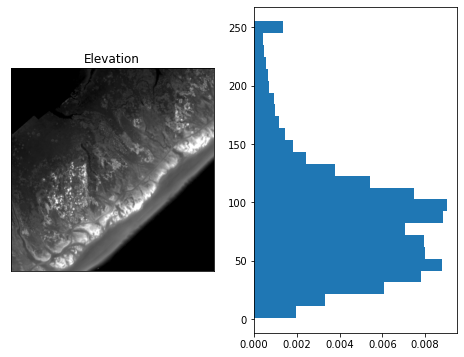

In [10]:
show_im_and_hist(elevr, 'Elevation')

### Use GDAL to calculate slope (degrees) from clipped DEM

In [11]:
in_dir = work_dir+dem_dir
dem_file = '/dem25_cubic.tiff'
in_file = in_dir+dem_file
out_dir = work_dir+dem_dir
slope_file = '/slope25_cubic.tiff'
out_file = out_dir+slope_file
gdal_cmd = 'gdaldem slope {} {} -of GTIFF -co COMPRESS=DEFLATE'.format(in_file, out_file)

print(gdal_cmd)

if os.system(gdal_cmd) == 0:
    print('Success')

gdaldem slope C:/crs/proj/2022_NOPP/Composite_Experiment/dem/dem25_cubic.tiff C:/crs/proj/2022_NOPP/Composite_Experiment/dem/slope25_cubic.tiff -of GTIFF -co COMPRESS=DEFLATE
Success


In [12]:
in_file = work_dir+dem_dir+slope_file
ds_slope = rio.open_rasterio(in_file)
slope = np.squeeze(np.array(ds_slope))
slope_shape = np.shape(slope)
sloper = np.ravel(slope)
sloper[np.where(sloper<= -200)]=np.nan
slope = np.reshape(slope, slope_shape)
print(np.sum(np.isnan(slope)))

116618432


Saving  C:/crs/proj/2022_NOPP/Composite_Experiment/figs/Slope_im_hist.jpg


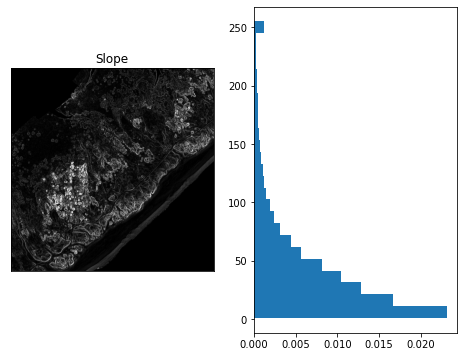

In [13]:
sloper = normalized_uint8(slope, pctile=1.)
show_im_and_hist(sloper, 'Slope')

### Cut out the ortho for that site
Keep as a geotiff for now.

In [14]:
infile = big_ortho_dir+big_ortho_fname
out_dir = work_dir+ortho_dir
ortho_file = '/ortho.tif'
out_file = out_dir+ortho_file

try:
    os.makedirs(out_dir)
    print('Created ',out_dir)
except FileExistsError:
    # directory already exists
    print(out_dir,'exists.')

gdal_cmd = 'gdal_translate -projwin {} {} {} {} -b 1 -b 2 -b 3 -of GTiff {} {}'.format(ulx, uly, lrx, lry, infile, out_file)
print(gdal_cmd)
if os.system(gdal_cmd) == 0:
    print('Success')
    os.system('gdalinfo {}'.format(out_file))

C:/crs/proj/2022_NOPP/Composite_Experiment/ortho exists.
gdal_translate -projwin 392750.0 3873000.0 396550.0 3870500.0 -b 1 -b 2 -b 3 -of GTiff C:/crs/proj/2019_DorianOBX/2021-07-27_FloSup_Products/ortho_cog/20190830_Ocracoke_Inlet_to_Ophelia_Inlet_RGBavg_NAD83_2011_UTM18_0.25m_cog.tif C:/crs/proj/2022_NOPP/Composite_Experiment/ortho/ortho.tif
Success


### Read in the ortho for other calcs using rioxarray

In [15]:
in_file = work_dir+ortho_dir+ortho_file
ds_ortho = rio.open_rasterio(in_file)
ds_ortho

<xarray.DataArray (band: 3, y: 10000, x: 15200)>
[456000000 values with dtype=uint8]
Coordinates:
  * band         (band) int32 1 2 3
  * x            (x) float64 3.928e+05 3.928e+05 ... 3.965e+05 3.965e+05
  * y            (y) float64 3.873e+06 3.873e+06 ... 3.871e+06 3.871e+06
    spatial_ref  int32 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

In [16]:
# pull bands out as arrays
r = np.array(ds_ortho[0].values).astype('float64')
g = np.array(ds_ortho[1].values).astype('float64')
b = np.array(ds_ortho[2].values).astype('float64')

### Make a grayscale image

In [17]:
gray = np.round((0.2989*r + 0.5870*g + 0.1140*b)).astype('uint8')

Saving  C:/crs/proj/2022_NOPP/Composite_Experiment/figs/Grayscale_im_hist.jpg


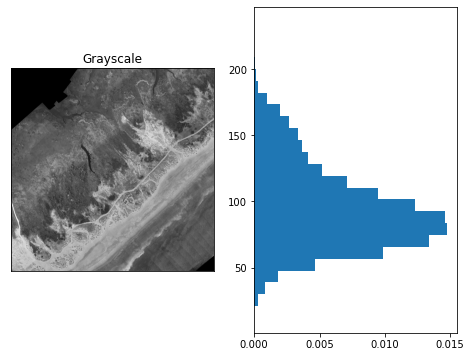

In [18]:
show_im_and_hist(gray, 'Grayscale')

### Make several different veg indices

In [19]:
GRRI = veg_func(r, g, b, name='GRRI', nan_val=0)
GRRIr = normalized_uint8( GRRI, nan_val = 0, pctile=1. )

Saving  C:/crs/proj/2022_NOPP/Composite_Experiment/figs/GRRIr_im_hist.jpg


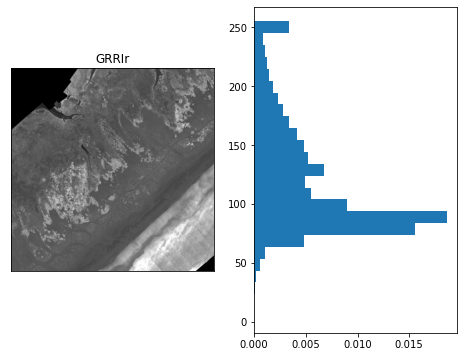

In [20]:
show_im_and_hist(GRRIr, 'GRRIr')

In [21]:
GRVI = veg_func(r, g, b, name='GRVI', nan_val=0)
GRVIr = normalized_uint8( GRVI, nan_val = 0, pctile=1. )

Saving  C:/crs/proj/2022_NOPP/Composite_Experiment/figs/GRVIr_im_hist.jpg


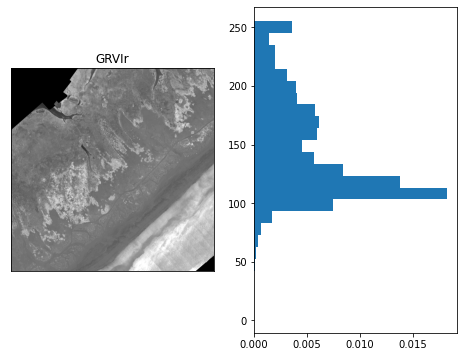

In [22]:
show_im_and_hist(GRVIr, 'GRVIr')

In [23]:
ExG = veg_func(r, g, b, name='ExG', nan_val=0)
ExGr = normalized_uint8( ExG, nan_val = 0, pctile=1. )

Saving  C:/crs/proj/2022_NOPP/Composite_Experiment/figs/ExGr_im_hist.jpg


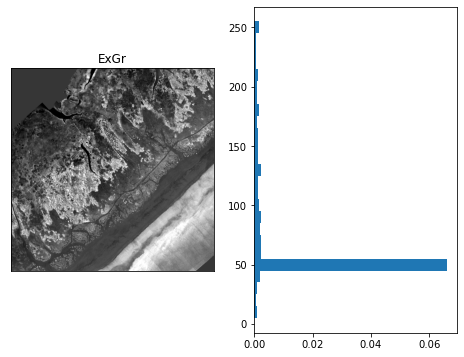

In [24]:
show_im_and_hist(ExGr, 'ExGr')

In [25]:
ExR = veg_func(r, g, b, name='ExR', nan_val=0)

Saving  C:/crs/proj/2022_NOPP/Composite_Experiment/figs/ExRr_im_hist.jpg


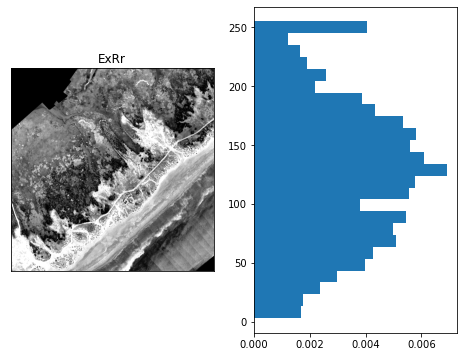

In [26]:
ExRr = normalized_uint8( ExR, nan_val = 0, pctile=1. )
show_im_and_hist(ExRr, 'ExRr')

### Function to assemble and write composites

In [27]:
comp_dir = work_dir+'/big_composites'
try:
    os.makedirs(comp_dir)
    print('Created ',comp_dir)
except FileExistsError:
    # directory already exists
    print(comp_dir,'exists.')
    
def make_composite( ds, b1, b2, b3, comp_dir, comp_name):
    ds[0:,:,:]=b1
    ds[1:,:,:]=b2
    ds[2:,:,:]=b3
    print('Making ',comp_dir+comp_name)
    ds.rio.to_raster(comp_dir+'/'+comp_name+'.tif')
    gdal_cmd = 'gdal_translate {} {} -of JPEG'.format(comp_dir+'/'+comp_name+'.tif',
                                                     comp_dir+'/'+comp_name+'.jpg')
    if os.system(gdal_cmd) == 0:
        print('Success')
        os.system('gdalinfo {}'.format(out_file))
        os.remove(comp_dir+'/'+comp_name+'.tif')


C:/crs/proj/2022_NOPP/Composite_Experiment/big_composites exists.


#### Available bands
* elevr
* sloper
* gray
* GRRIr
* GRVIr
* ExGr
* ExRr

### Make some composite images

In [28]:
make_composite(ds_ortho, gray, ExRr, elevr, comp_dir, 'gray_exrr_elevr' )

Making  C:/crs/proj/2022_NOPP/Composite_Experiment/big_compositesgray_exrr_elevr
Success


In [29]:
make_composite(ds_ortho, gray, GRRIr, elevr, comp_dir, 'gray_grrir_elevr' )

Making  C:/crs/proj/2022_NOPP/Composite_Experiment/big_compositesgray_grrir_elevr
Success


In [30]:
make_composite(ds_ortho, gray, ExRr, slope, comp_dir, 'gray_exrr_slope' )

Making  C:/crs/proj/2022_NOPP/Composite_Experiment/big_compositesgray_exrr_slope
Success


In [31]:
make_composite(ds_ortho, GRRIr, gray, elevr, comp_dir, 'grrir_gray_elevr' )

Making  C:/crs/proj/2022_NOPP/Composite_Experiment/big_compositesgrrir_gray_elevr
Success


In [32]:
make_composite(ds_ortho, gray, GRVIr, elevr, comp_dir, 'gray_grvir_elevr' )

Making  C:/crs/proj/2022_NOPP/Composite_Experiment/big_compositesgray_grvir_elevr
Success
